In [113]:
import numpy as np
import dask , dask.distributed
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cmocean.cm as cmo
import warnings
warnings.simplefilter('ignore')
import dask_jobqueue
from astropy.convolution import Box2DKernel, convolve
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import matplotlib.colors as colors
import pandas as pd
from fix_grid import fix_grid 
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from useful_calculations import weighted_means
from scipy import stats

In this script, a new categorization system including wind was tested

In [21]:
ds_mom=xr.open_dataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/MOM5_concat/0181-0190/MOM5_monthly_0181-0190_noice_all.nc')
pathp='/gxfs_home/geomar/smomw577/plots/Boxcar/0181-0190/'
pathf='/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/0181-0190/'
dsa=xr.open_dataset(pathf+'3x3box_median_anomaly_monthly_0181-0190_all.nc')
corr=xr.open_dataset(pathf+'3x3box_median_corr_monthly_0181-0190_all.nc')
ds=xr.open_dataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/MOM5_concat/0181-0190/mean_std_control_noice.nc', chunks='auto')
ds_cc=xr.open_dataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/MOM5_concat/0181-0190/mean_std_1PctTo2X_noice.nc', chunks='auto')

In [22]:
ds_mom=fix_grid(ds_mom)
dsa=fix_grid(dsa)
corr=fix_grid(corr)
ds=fix_grid(ds)
ds_cc=fix_grid(ds_cc)

In [23]:
##!!!!run this only if the chapter "save masks in file" was already run!!!!

ds_mask=xr.open_dataset(pathf+'mask_gases_total.nc')
ds_mask_cc=xr.open_dataset(pathf+'mask_gases_total_cc.nc')
mask=fix_grid(ds_mask)
mask_cc=fix_grid(ds_mask_cc)


###!!!!run only when categorization was run one time already!!!!

combined_mask_cc=xr.open_dataset(pathf+'categorization_wind_1PctTo2X.nc')
combined_mask_cc=fix_grid(combined_mask_cc)
cat=xr.open_dataset(pathf+'categorization_wind.nc').__xarray_dataarray_variable__
cat=fix_grid(cat)
windano=xr.open_dataset(pathf+'3x3box_median_anomaly_monthly_0181-0190_wind.nc').wind_stress
windano=fix_grid(windano)

# find areas

In [106]:
####CO2 and O2 mean outgassing
mask1=xr.where((ds_mom.dic_stf<0) & (ds_mom.o2_stf <0),1, np.nan)

In [107]:
####CO2 outgassing and O2 mean ingassing
mask2=xr.where((ds_mom.dic_stf<0) & (ds_mom.o2_stf >0),1,np.nan)

In [108]:
####CO2 ingassing, O2 outgassing
mask3=xr.where((ds_mom.dic_stf>0) & (ds_mom.o2_stf <0),1,np.nan)

In [109]:
####CO2 ingassing, O2 ingassing
mask4=xr.where((ds_mom.dic_stf>0) & (ds_mom.o2_stf >0),1,np.nan)

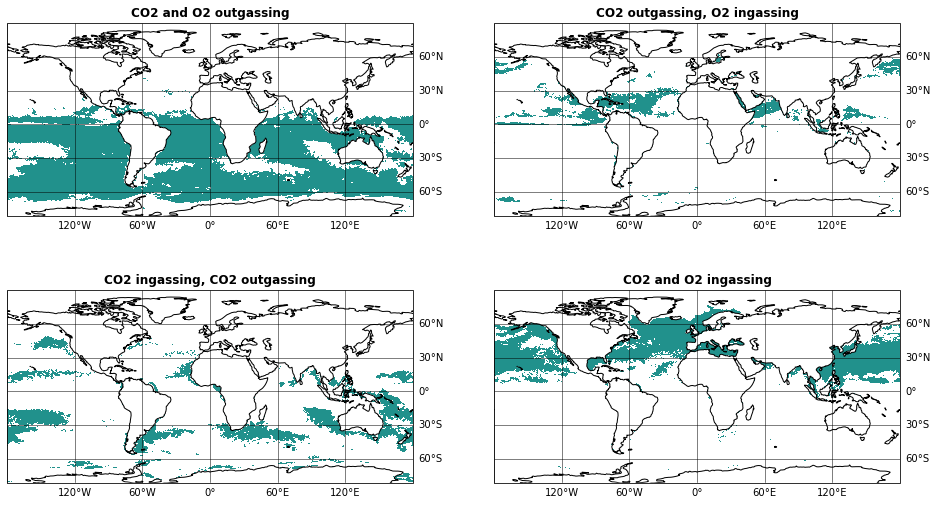

In [53]:
fig, axs= plt.subplots(nrows=2, ncols=2 , figsize=(16,9),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
mask1.isel(time=0).plot(ax=axs[0],x='geolon_t', y='geolat_t', add_colorbar=False, transform=ccrs.PlateCarree())
mask2.isel(time=0).plot(ax=axs[1],x='geolon_t', y='geolat_t', add_colorbar=False, transform=ccrs.PlateCarree())
mask3.isel(time=0).plot(ax=axs[2],x='geolon_t', y='geolat_t', add_colorbar=False, transform=ccrs.PlateCarree())
mask4.isel(time=0).plot(ax=axs[3],x='geolon_t', y='geolat_t', add_colorbar=False, transform=ccrs.PlateCarree())

for i in range(4):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_left = False
    axs[i].coastlines()
axs[0].set_title('CO2 and O2 outgassing', fontweight='bold');
axs[1].set_title('CO2 outgassing, O2 ingassing', fontweight='bold');
axs[2].set_title('CO2 ingassing, CO2 outgassing', fontweight='bold');
axs[3].set_title('CO2 and O2 ingassing', fontweight='bold')

plt.savefig(pathp+'gasflux_inout_exemplaryday.png', dpi=300, bbox_inches='tight');


In [15]:
from matplotlib.colors import ListedColormap
import matplotlib
col_dict = {1: "royalblue",
            2: "cornflowerblue",
            3: "indianred",
            4: "#B22222"}
            #7: "green"}
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
labels = np.array(["FCO2 out / FO2 out", "FCO2 in / FO2 in", "FCO2 out / FO2 in", "FCO2 in / FO2 out"])
len_lab = len(labels)
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

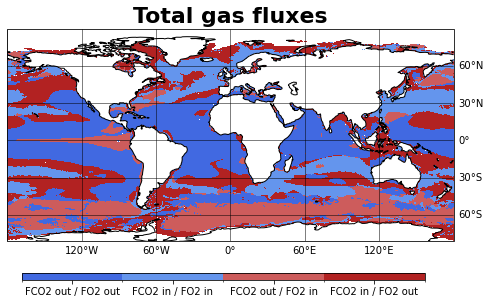

In [16]:
fig, axs= plt.subplots(nrows=1, ncols=1 , figsize=(8,5),subplot_kw={'projection': ccrs.PlateCarree()})
im1=xr.where((ds.dic_stf_mean<0) & (ds.o2_stf_mean <0),1, np.nan).plot(x='geolon_t', y='geolat_t', add_colorbar=False, cmap=cm,norm=norm,transform=ccrs.PlateCarree())
xr.where((ds.dic_stf_mean>0) & (ds.o2_stf_mean >0),2, np.nan).plot(x='geolon_t', y='geolat_t', add_colorbar=False, cmap=cm,norm=norm,transform=ccrs.PlateCarree())
xr.where((ds.dic_stf_mean<0) & (ds.o2_stf_mean >0),3, np.nan).plot(x='geolon_t', y='geolat_t', add_colorbar=False, cmap=cm,norm=norm,transform=ccrs.PlateCarree())
xr.where((ds.dic_stf_mean>0) & (ds.o2_stf_mean <0),4, np.nan).plot(x='geolon_t', y='geolat_t', add_colorbar=False, cmap=cm,norm=norm,transform=ccrs.PlateCarree())

gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.5)
gl.xlabels_top = False
gl.ylabels_left = False
axs.coastlines()
axs.set_title('Total gas fluxes', fontweight='bold', fontsize=22);
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cbar_ax = fig.add_axes([0.15, 0.1, 0.70, 0.02])
cb = fig.colorbar(im1, cax=cbar_ax,orientation='horizontal', format=fmt, ticks=tickz);

plt.savefig(pathp+'gasflux_inout_mean.png', dpi=300, bbox_inches='tight');


# save masks in file

In [23]:
def create_mask(ds):
    mask11=xr.where((ds.dic_stf_mean<0) & (ds.o2_stf_mean <0),1, np.nan)
    mask22=xr.where((ds.dic_stf_mean<0) & (ds.o2_stf_mean >0),1, np.nan)
    mask33=xr.where((ds.dic_stf_mean>0) & (ds.o2_stf_mean <0),1, np.nan)
    mask44=xr.where((ds.dic_stf_mean>0) & (ds.o2_stf_mean >0),1, np.nan)
    mask11.name='CO2outO2out'
    mask22.name='CO2outO2in'
    mask33.name='CO2inO2out'
    mask44.name='CO2inO2in'
    return xr.merge([mask11,mask22,mask33,mask44])

In [24]:
create_mask(ds).to_netcdf(pathf+'mask_gases_total.nc')
create_mask(ds_cc).to_netcdf(pathf+'mask_gases_total_cc.nc')

# masks in fraction

In [24]:
#for each timestep
mask1=xr.where((ds_mom.dic_stf<0) & (ds_mom.o2_stf <0),1, np.nan)
mask2=xr.where((ds_mom.dic_stf<0) & (ds_mom.o2_stf >0),1,np.nan)
mask3=xr.where((ds_mom.dic_stf>0) & (ds_mom.o2_stf <0),1,np.nan)
mask4=xr.where((ds_mom.dic_stf>0) & (ds_mom.o2_stf >0),1,np.nan)

In [25]:
#then sum up the ones and divide by 1.2 because of 12 months and fraction in per cent

mask1f=mask1.sum(dim='time', skipna=True)/1.2
mask2f=mask2.sum(dim='time', skipna=True)/1.2
mask3f=mask3.sum(dim='time', skipna=True)/1.2
mask4f=mask4.sum(dim='time', skipna=True)/1.2
mask1f = mask1f.where(ds_mom.SST.isel(time=0).notnull())
mask2f = mask2f.where(ds_mom.SST.isel(time=0).notnull())
mask3f = mask3f.where(ds_mom.SST.isel(time=0).notnull())
mask4f = mask4f.where(ds_mom.SST.isel(time=0).notnull())

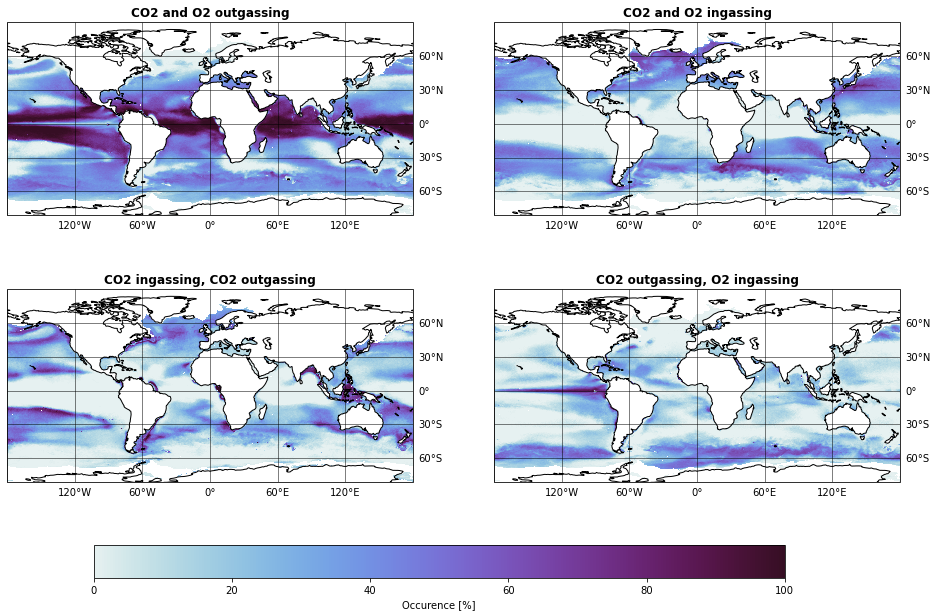

In [27]:
#plotting

fig, axs= plt.subplots(nrows=2, ncols=2 , figsize=(16,9),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
im=mask1f.plot(ax=axs[0],vmin=0, vmax=100, x='geolon_t', y='geolat_t',cmap=cmo.dense, add_colorbar=False, transform=ccrs.PlateCarree())
mask2f.plot(ax=axs[3],vmin=0, vmax=100, x='geolon_t', y='geolat_t',cmap=cmo.dense, add_colorbar=False, transform=ccrs.PlateCarree())
mask3f.plot(ax=axs[2],vmin=0, vmax=100, x='geolon_t', y='geolat_t',cmap=cmo.dense, add_colorbar=False, transform=ccrs.PlateCarree())
mask4f.plot(ax=axs[1],vmin=0, vmax=100, x='geolon_t', y='geolat_t',cmap=cmo.dense, add_colorbar=False, transform=ccrs.PlateCarree())

for i in range(4):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_left = False
    axs[i].coastlines()
axs[0].set_title('CO2 and O2 outgassing', fontweight='bold');
axs[3].set_title('CO2 outgassing, O2 ingassing', fontweight='bold');
axs[2].set_title('CO2 ingassing, CO2 outgassing', fontweight='bold');
axs[1].set_title('CO2 and O2 ingassing', fontweight='bold')

cbar_ax = fig.add_axes([0.2, 0.0, 0.6, 0.05])  # Left, bottom, width, height.
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Occurence [%]')
plt.savefig(pathp+'gasflux_inout_fraction.png', dpi=300, bbox_inches='tight');


# new categorization

In [27]:
def categorization (dscorr, mask, ctrl_cc):
    ###this function is creating a categorized dataset 
    ##input: dscorr=dataset with correlations
    #mask= ds, mask of sign of gas fluxes
    # ctrl_cc= string either 'Ctrl' or 'CC' for Control run or climate change run
    # 1 solubility
    # 2 wind sol
    # 3 wind
    # 4 bio no wind
    # 5 bio wind
    # 6 upwelling no wind
    # 7 upwelling wind
    # 8 rest
        
    ###LEFT side of the diagram
    if ctrl_cc =='Ctrl':
        corr=dscorr.corr_o2_stf_dic_stf 
        corr_jp=dscorr.corr_jp_dic_stf_ctrl
        corr_mld=dscorr.corr_mld_dic_stf_ctrl
    elif ctrl_cc=='CC':
        corr=dscorr.corr_o2_stf_dic_stf_1PctTo2X 
        corr_jp=dscorr.corr_jp_dic_stf_1PctTo2X
        corr_mld=dscorr.corr_mld_dic_stf_1PctTo2X
    
    _wind_11_=xr.where(corr > 0, 1,np.nan)
    _wind_12_=xr.where((mask.CO2outO2out==1) | (mask.CO2inO2in==1),1,np.nan)
    ### only solubility is where we have a positive correlation between co2 and o2 anomalies and the sign of absolute fields in not the same
    solubility_ctrl=xr.where((_wind_11_==1) & (_wind_12_!=1),1,np.nan)
    ### but it can also be the wind if the absolute fields have the same sign out/ingassing
    wind_1=xr.where((_wind_11_==1) & (_wind_12_==1), 2,np.nan)
    
    ###RIGHT side of the diagram
    _wind_21_=xr.where(corr<0, 1,np.nan) ###corr o2/co2 anomaly negative
    _wind_22_=xr.where((mask.CO2outO2in==1) | (mask.CO2inO2out==1),1,np.nan) ### absolute fluxes are of opposite sign

    #its wind if anomalies have negative correlation and the abs fluxes are of opposite sign
    wind_2=xr.where((_wind_21_==1) & (_wind_22_==1), 3,np.nan)
    
    ##its only biology when there is a correlation with jp but its not wind
    biologie_ctrl=xr.where((corr<0) & (corr_jp > 0) & (wind_2 != 3), 4,np.nan)
    
    ##but if there is biology and wind, it can be both
    biologie_ctrl_wind=xr.where((corr<0) & (corr_jp > 0) & (wind_2 == 3), 5,np.nan)
    
    #its only upwelling when there is a correlation with mld but its not wind
    upwelling_ctrl=xr.where((corr<0) & (corr_mld > 0)& (wind_2 != 3), 6,np.nan)
    
    ##but if there is upwelling and wind, it can be both
    upwelling_ctrl_wind=xr.where((corr<0) & (corr_mld> 0)& (wind_2 == 3), 7,np.nan)
    
    ###now, find areas where there is both biology and upwelling (wind and no wind)
    both_ctrl=xr.where((biologie_ctrl==4)& (upwelling_ctrl==6) , 8,np.nan)
    both_ctrl_wind=xr.where((biologie_ctrl_wind==5)& (upwelling_ctrl_wind==7), 9,np.nan)
    
    
    ##Dominanz von Bio oder Upwelling Korrelation mit CO2
    __both_bio=xr.where((both_ctrl==8)& (corr_jp >corr_mld),1,np.nan)
    ##or it has always just been biology
    __just_bio=xr.where((biologie_ctrl==4) & (both_ctrl !=8),1,np.nan)
    #both are then category --> just bio
    biologie_ctrl=xr.where((__both_bio==1)| (__just_bio==1), 4, np.nan)
    
    #dominance of bio in the section bio or upwelling or wind
    __both_bio_wind=xr.where((both_ctrl_wind==9)& (corr_jp>corr_mld),1,np.nan)
    #or it was never with upwelling
    __just_bio_wind=xr.where((biologie_ctrl_wind==5) & (both_ctrl_wind !=9),1,np.nan)
    #then this is category bio and wind
    biologie_ctrl_wind=xr.where((__both_bio_wind==1)| (__just_bio_wind==1), 5, np.nan)
    
    ##same thing with upwelling, check for dominance without wind
    __both_upw=xr.where((both_ctrl==8)& (corr_jp<corr_mld),1,np.nan)
    #or it was always just upwelling anyway
    __just_upw=xr.where((upwelling_ctrl==6) & (both_ctrl !=8),1,np.nan)
    #then its upwelling
    upwelling_ctrl=xr.where((__both_upw==1)| (__just_upw==1), 6, np.nan)
    
    ##same thing with upwelling, check for dominance with wind
    __both_upw_wind=xr.where((both_ctrl_wind==9)& (corr_jp <corr_mld),1,np.nan)
    #or it was always just upwelling with wind, no bio
    __just_upw_wind=xr.where((upwelling_ctrl_wind==7) & (both_ctrl_wind !=9),1,np.nan)
    #then its upwelling or wind
    upwelling_ctrl_wind=xr.where((__both_upw_wind==1)| (__just_upw_wind==1), 7, np.nan)
    
    ###rest
    dom= xr.full_like(__both_bio, fill_value=0, dtype=int)
    dom=dom.where(biologie_ctrl!=4,1)
    dom=dom.where(upwelling_ctrl!=6,1)
    dom = dom.where(dom!=0, np.nan)

    dom_wind= xr.full_like(__both_bio, fill_value=0, dtype=int)
    dom_wind=dom_wind.where(biologie_ctrl_wind!=4,1)
    dom_wind=dom_wind.where(upwelling_ctrl_wind!=6,1)
    dom_wind = dom_wind.where(dom!=0, np.nan)
    
    __both__=xr.where((dom==1) | (dom_wind==1),1,np.nan)
    rest=xr.where((_wind_21_==1) &(__both__!=1) &(wind_2!=3) ,8,np.nan)
    ###combine everything
    combined_mask = xr.full_like(solubility_ctrl, fill_value=0, dtype=int)
    combined_mask = combined_mask.where(solubility_ctrl!=1, 1)
    combined_mask = combined_mask.where(wind_1!=2, 2)
    combined_mask = combined_mask.where(wind_2!=3, 3)
    combined_mask = combined_mask.where(biologie_ctrl!=4, 4)
    combined_mask = combined_mask.where(biologie_ctrl_wind!=5, 5)
    combined_mask = combined_mask.where(upwelling_ctrl!=6, 6)
    combined_mask = combined_mask.where(upwelling_ctrl_wind!=7, 7)
    combined_mask = combined_mask.where(rest!=8, 8)
    combined_mask = combined_mask.where(combined_mask!=0, np.nan)

    return combined_mask

In [28]:
##ctrl
combined_mask_ctrl=categorization (corr, mask, "Ctrl")
##CC
combined_mask_cc=categorization (corr, mask_cc, "CC")

In [29]:
combined_mask_ctrl.to_netcdf(pathf+'categorization_wind.nc')
combined_mask_cc.to_netcdf(pathf+'categorization_wind_1PctTo2X.nc')

# Plotting

In [14]:
##custom colormap
from matplotlib.colors import ListedColormap
import matplotlib
col_dict = {1: "#9467bd",
            2: "#c5b0d5",
            3: "#5fa2d5",
            4: "#2ca02c",
            5: "#98df8a",
            6: "#d62728",
            7: "#ff9896",
            8: "#ff7f0e",}
            #7: "green"}
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
labels = np.array(["sol\nonly", "sol\nor wind\n++/--", "wind\n+-/-+", "bio\nonly","bio or\nwind", "upw\nonly", "upw or\nwind", "rest"])
len_lab = len(labels)
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

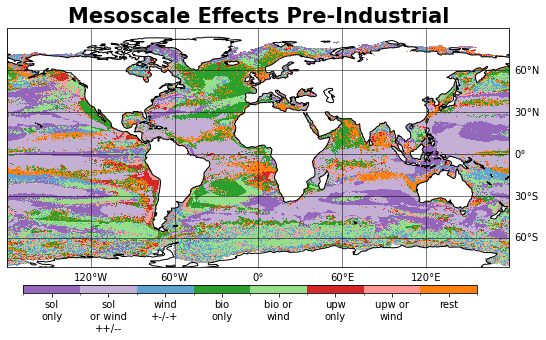

In [32]:
#plotting new categorization system
fig, axs= plt.subplots(nrows=1, ncols=1 , figsize=(9,5),subplot_kw={'projection': ccrs.PlateCarree()})
pic=combined_mask_ctrl.plot(x='geolon_t', y='geolat_t', transform = ccrs.PlateCarree(), add_colorbar=False, cmap=cm,norm=norm)
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.5)
gl.xlabels_top = False
gl.ylabels_left = False
axs.coastlines()
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cbar_ax = fig.add_axes([0.15, 0.1, 0.70, 0.02])
cb = fig.colorbar(pic, cax=cbar_ax,orientation='horizontal', format=fmt, ticks=tickz)
axs.set_title('Mesoscale Effects Pre-Industrial', fontweight='bold', fontsize=21);
plt.savefig(pathp+'mesoscale_effects_wind_ctrl_median.png', dpi=300, bbox_inches='tight');

## Ctrl and Climate Change in one plot

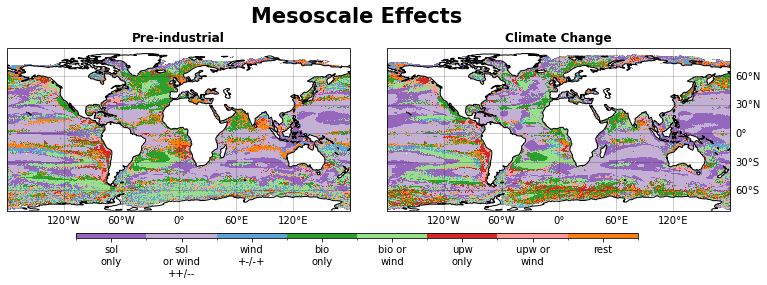

In [36]:
fig = plt.figure(figsize=(13,3),layout='compressed')
gs = gridspec.GridSpec(1, 2, width_ratios=[4,4], wspace=.1, hspace=.1)
ax1 = fig.add_subplot(gs[0],projection=ccrs.PlateCarree(central_longitude=0))
ax2 = fig.add_subplot(gs[1],projection=ccrs.PlateCarree(central_longitude=0))

#
#
im1=combined_mask_ctrl.plot(ax=ax1, x='geolon_t', y='geolat_t',cmap=cm,norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)#, cbar_kwargs={'orientation':'horizontal','label': "mean CO2 flux [mmol/m^2*yr]"})

im2=combined_mask_cc.plot(ax=ax2, x='geolon_t', y='geolat_t',cmap=cm,norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)#, cbar_kwargs={'orientation':'horizontal','label': "mean CO2 flux [mmol/m^2*yr]"})

axs=[ax1, ax2]
for i in axs:
        gl = i.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=1, color='black', alpha=0.2)
        gl.xlabels_top = False
        gl.ylabels_left = False
        i.coastlines()
        if i==ax1:
            gl.ylabels_right=False
#
###TITLES AND LABELS
ax1.set_title('Pre-industrial', fontweight='bold');
ax2.set_title('Climate Change', fontweight='bold');
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cbar_ax = fig.add_axes([0.2, 0, 0.6, 0.02])
cb = fig.colorbar(im1, cax=cbar_ax,orientation='horizontal', format=fmt, ticks=tickz);
plt.suptitle('Mesoscale Effects', fontweight='bold', fontsize=21, y=1.07);

plt.savefig(pathp+'mesoscale_effects_wind_median.png', dpi=300, bbox_inches='tight');

# make wind have its own color

In [47]:
#combine wind only, bio and wind, sol and wind and upwelling and wind
combined_new=  xr.where((combined_mask_ctrl == 3) | (combined_mask_ctrl == 5)| (combined_mask_ctrl == 7), 2, combined_mask_ctrl)

In [48]:
#new custom colormap
col_dict = {1: "#9467bd",
            2: "#1f77b4",
            4: "#2ca02c",
           6: "#d62728",
           8: "#ff7f0e"}
            #7: "green"}
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
labels = np.array(["sol", "wind", "bio","upw", "bio &\nupw"])
len_lab = len(labels)
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

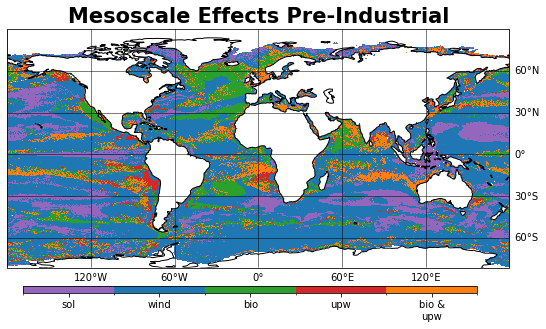

In [50]:
#plotting
fig, axs= plt.subplots(nrows=1, ncols=1 , figsize=(9,5),subplot_kw={'projection': ccrs.PlateCarree()})
pic=combined_new.plot(x='geolon_t', y='geolat_t', transform = ccrs.PlateCarree(), add_colorbar=False, cmap=cm,norm=norm)
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.5)
gl.xlabels_top = False
gl.ylabels_left = False
axs.coastlines()
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cbar_ax = fig.add_axes([0.15, 0.1, 0.70, 0.02])
cb = fig.colorbar(pic, cax=cbar_ax,orientation='horizontal', format=fmt, ticks=tickz)
axs.set_title('Mesoscale Effects Pre-Industrial', fontweight='bold', fontsize=21);
plt.savefig(pathp+'mesoscale_effects_wind_ctrl_median_alt2.png', dpi=300, bbox_inches='tight');

# easier version without upwelling

In [6]:
##put everything upwelling into 'rest'
combined_easy_ctrl=xr.where((combined_mask_ctrl == 8), 6, combined_mask_ctrl)
combined_easy_ctrl=xr.where((combined_easy_ctrl == 7),3, combined_easy_ctrl)

combined_easy_cc=xr.where((combined_mask_cc == 8), 6, combined_mask_cc)
combined_easy_cc=xr.where((combined_easy_cc == 7),3, combined_easy_cc)

In [38]:
from matplotlib.colors import ListedColormap
import matplotlib
col_dict = {1: "#9467bd",
            2: "#c5b0d5",
            3: "#5fa2d5",
            4: "#2ca02c",
           5: "#98df8a",
           6: "#ff7f0e"}
            #7: "green"}
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
labels = np.array(["sol\nonly", "sol\nor wind\n++/--", "wind\n+-/-+", "bio\nonly","bio or\nwind", "rest"])
len_lab = len(labels)
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

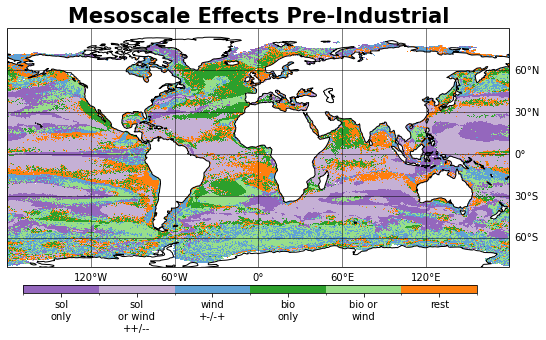

In [62]:
fig, axs= plt.subplots(nrows=1, ncols=1 , figsize=(9,5),subplot_kw={'projection': ccrs.PlateCarree()})
pic=combined_easy_ctrl.plot(x='geolon_t', y='geolat_t', transform = ccrs.PlateCarree(), add_colorbar=False, cmap=cm,norm=norm)
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.5)
gl.xlabels_top = False
gl.ylabels_left = False
axs.coastlines()
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cbar_ax = fig.add_axes([0.15, 0.1, 0.70, 0.02])
cb = fig.colorbar(pic, cax=cbar_ax,orientation='horizontal', format=fmt, ticks=tickz)
axs.set_title('Mesoscale Effects Pre-Industrial', fontweight='bold', fontsize=21);
plt.savefig(pathp+'mesoscale_effects_wind_ctrl_median_alt.png', dpi=300, bbox_inches='tight');

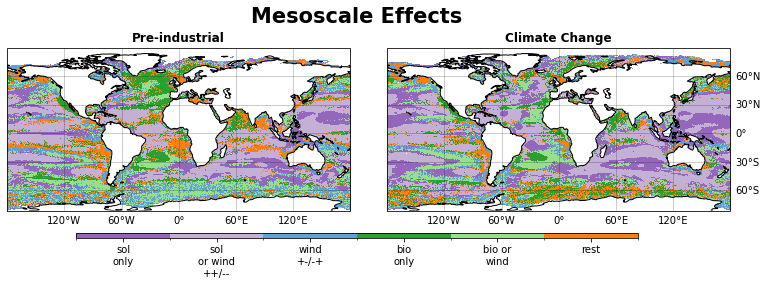

In [39]:
fig = plt.figure(figsize=(13,3),layout='compressed')
gs = gridspec.GridSpec(1, 2, width_ratios=[4,4], wspace=.1, hspace=.1)
ax1 = fig.add_subplot(gs[0],projection=ccrs.PlateCarree(central_longitude=0))
ax2 = fig.add_subplot(gs[1],projection=ccrs.PlateCarree(central_longitude=0))

#
#
im1=combined_easy_ctrl.plot(ax=ax1, x='geolon_t', y='geolat_t',cmap=cm,norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)#, cbar_kwargs={'orientation':'horizontal','label': "mean CO2 flux [mmol/m^2*yr]"})

im2=combined_easy_cc.plot(ax=ax2, x='geolon_t', y='geolat_t',cmap=cm,norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)#, cbar_kwargs={'orientation':'horizontal','label': "mean CO2 flux [mmol/m^2*yr]"})

axs=[ax1, ax2]
for i in axs:
        gl = i.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=1, color='black', alpha=0.2)
        gl.xlabels_top = False
        gl.ylabels_left = False
        i.coastlines()
        if i==ax1:
            gl.ylabels_right=False
#
###TITLES AND LABELS
ax1.set_title('Pre-industrial', fontweight='bold');
ax2.set_title('Climate Change', fontweight='bold');
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cbar_ax = fig.add_axes([0.2, 0, 0.6, 0.02])
cb = fig.colorbar(im1, cax=cbar_ax,orientation='horizontal', format=fmt, ticks=tickz);
plt.suptitle('Mesoscale Effects', fontweight='bold', fontsize=21, y=1.07);

plt.savefig(pathp+'mesoscale_effects_wind_median_alt.png', dpi=300, bbox_inches='tight');

# scatters of example regions

In [30]:
sol=corr.where(cat==1).corr_o2_stf_dic_stf
solw=corr.where(cat==2).corr_o2_stf_dic_stf
wind=corr.where(cat==3).corr_o2_stf_dic_stf
bio=corr.where(cat==4).corr_o2_stf_dic_stf
biow=corr.where(cat==5).corr_o2_stf_dic_stf
upw=corr.where(cat==6).corr_o2_stf_dic_stf
upww=corr.where(cat==7).corr_o2_stf_dic_stf
rest=corr.where(cat==8).corr_o2_stf_dic_stf

In [40]:
weighted_means([sol, solw, wind, bio, biow, upw,upww, rest], ['sol', 'solw', 'wind', 'bio', 'biow', 'upw','upww', 'rest'])

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    st_ocean  float64 5.034
Data variables:
    sol       float64 0.281
    solw      float64 0.296
    wind      float64 -0.4439
    bio       float64 -0.3573
    biow      float64 -0.4497
    upw       float64 -0.3287
    upww      float64 -0.4379
    rest      float64 -0.2926

In [ ]:
### pick out a data point from "solubility" and "solubility or wind" region to see correlation

In [ ]:
### lets start with "solubility and wind region"

In [26]:
def random_point(ds, condition):
    ###this function finds a random point which matches given criteria in a dataset
    region=ds.where(condition)
    valid_points=region.where(region==region.max(), drop=True)
    stacked = valid_points.stack(points=('yt_ocean', 'xt_ocean')).dropna('points')
    if stacked.size > 0:
        random_index = np.random.randint(stacked.size)
        random_point = stacked.isel(points=random_index)
        # compute everything first
        random_point = random_point.compute()
        
        y_coord = random_point['yt_ocean'].item()
        x_coord = random_point['xt_ocean'].item()
        y_geocoord = random_point['geolat_t'].item()
        x_geocoord = random_point['geolon_t'].item()
        value = random_point.item()
    
        print(f"Selected point at yt_ocean={y_coord}, xt_ocean={x_coord}, geolat_t={y_geocoord}, geolon_t={x_geocoord} with value {value}")
        return y_coord, x_coord, y_geocoord, x_geocoord

In [27]:
outout=xr.where((ds.dic_stf_mean<0) & (ds.o2_stf_mean <0),1, np.nan)
inin=xr.where((ds.dic_stf_mean>0) & (ds.o2_stf_mean >0),1, np.nan)

In [12]:
y_coord_outout, x_coord_outout, y_geocoord_outout, x_geocoord_outout=random_point(mask1f,(cat==2)&(outout==1))###solubility and wind out/out

Selected point at yt_ocean=1.2499014677070654, xt_ocean=-215.24999999999687, geolat_t=1.2499014677070654, geolon_t=-215.24999999999687 with value 100.0


In [39]:
y_coord_inin, x_coord_inin, y_geocoord_inin, x_geocoord_inin=random_point(mask4f, (cat==2)&(inin==1)&(mask4f.xt_ocean<-120)&(mask4f.xt_ocean>-180)&(mask4f.yt_ocean<30)&(mask4f.yt_ocean>-30)) ###solubility and wind in/in

Selected point at yt_ocean=18.518884181775963, xt_ocean=-155.15000000000032, geolat_t=18.518884181775963, geolon_t=-155.15000000000032 with value 95.0


In [51]:
y_coord_sol, x_coord_sol, y_geocoord_sol, x_geocoord_sol=random_point(sol, (sol.yt_ocean<=30)& (sol.yt_ocean>=-30)&(sol.xt_ocean<=-100)&(sol.xt_ocean>=-160))

Selected point at yt_ocean=23.189660644996728, xt_ocean=-131.15000000000168, geolat_t=23.189660644996728, geolon_t=-131.15000000000168 with value 0.7855496605707055


# scatters

## random location

In [43]:
y_geocoord_outout, x_geocoord_outout=1.2499014677070654,-215.24999999999687
y_geocoord_inin, x_geocoord_inin=18.518884181775963, -155.15000000000032
y_geocoord_sol, x_geocoord_sol=23.189660644996728, -131.15000000000168

In [96]:
point1=dsa.sel(xt_ocean=x_geocoord_outout, method='nearest').sel(yt_ocean=y_geocoord_outout, method='nearest')
point2=dsa.sel(xt_ocean=x_geocoord_inin, method='nearest').sel(yt_ocean=y_geocoord_inin, method='nearest')
point3=dsa.sel(xt_ocean=x_geocoord_sol, method='nearest').sel(yt_ocean=y_geocoord_sol, method='nearest')

corr1=corr[['corr_sst_dic_stf', 'corr_sst_o2_stf']].sel(xt_ocean=x_geocoord_outout, method='nearest').sel(yt_ocean=y_geocoord_outout, method='nearest')
corr2=corr[['corr_sst_dic_stf', 'corr_sst_o2_stf']].sel(xt_ocean=x_geocoord_inin, method='nearest').sel(yt_ocean=y_geocoord_inin, method='nearest')
corr3=corr[['corr_sst_dic_stf', 'corr_sst_o2_stf']].sel(xt_ocean=x_geocoord_sol, method='nearest').sel(yt_ocean=y_geocoord_sol, method='nearest')

In [109]:
corrs=[str(round(float(corr1.corr_sst_dic_stf.values),3)), str(round(float(corr2.corr_sst_dic_stf.values),3)), str(round(float(corr3.corr_sst_dic_stf.values),3)),str(round(float(corr1.corr_sst_o2_stf.values),3)),str(round(float(corr2.corr_sst_o2_stf.values),3)),str(round(float(corr3.corr_sst_o2_stf.values),3))]

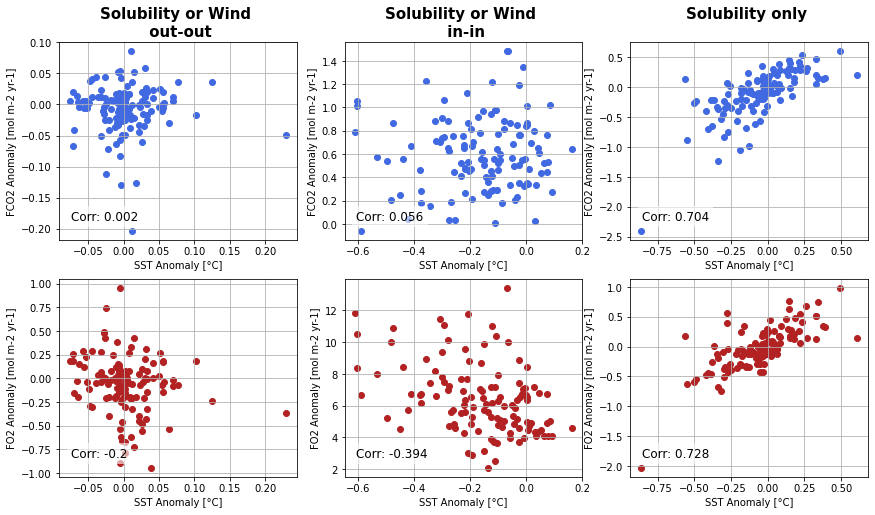

In [113]:
fig, axs=plt.subplots(nrows=2, ncols=3, figsize=(14.5,8))
axs=axs.flatten()
axs[0].scatter(point1.SST, point1.dic_stf, c='royalblue')
axs[3].scatter(point1.SST, point1.o2_stf, c='firebrick')

axs[1].scatter(point2.SST, point2.dic_stf, c='royalblue')
axs[4].scatter(point2.SST, point2.o2_stf, c='firebrick')

axs[2].scatter(point3.SST, point3.dic_stf, c='royalblue')
axs[5].scatter(point3.SST, point3.o2_stf, c='firebrick')

for i in range (3):
    axs[i].set_ylabel('FCO2 Anomaly [mol m-2 yr-1]')
for i in range (3,6):
    axs[i].set_ylabel('FO2 Anomaly [mol m-2 yr-1]')
for i in range(6):
    axs[i].set_xlabel('SST Anomaly [°C]')
    axs[i].grid()
    axs[i].text(0.05, 0.15, 'Corr: '+ corrs[i],
            transform=axs[i].transAxes,
            fontsize=12,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

axs[0].set_title('Solubility or Wind \n out-out', fontweight='bold', fontsize=15)
axs[1].set_title('Solubility or Wind \n in-in', fontweight='bold', fontsize=15)
axs[2].set_title('Solubility only \n', fontweight='bold', fontsize=15)
plt.savefig(pathp+'scatter_solubility_regions.png', dpi=300, bbox_inches='tight')

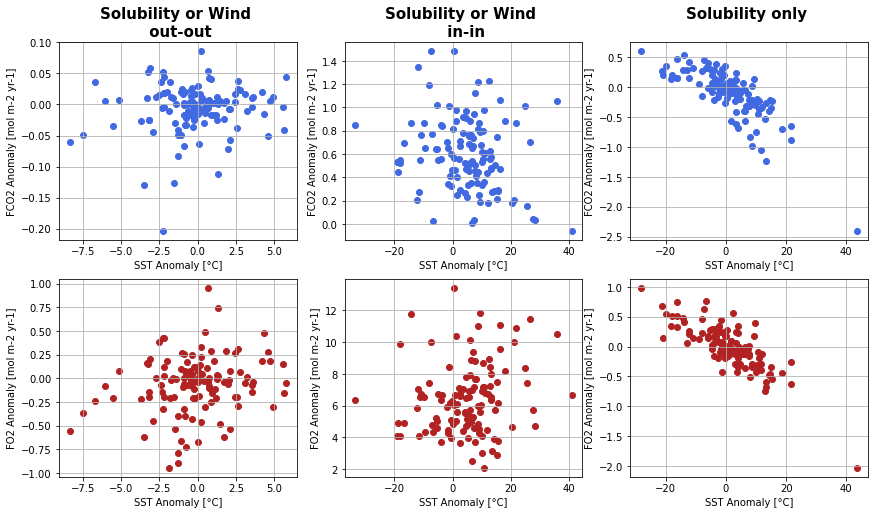

In [119]:
fig, axs=plt.subplots(nrows=2, ncols=3, figsize=(14.5,8))
axs=axs.flatten()
axs[0].scatter(point1.sens_heat+point1.evap_heat, point1.dic_stf, c='royalblue')
axs[3].scatter(point1.sens_heat+point1.evap_heat, point1.o2_stf, c='firebrick')

axs[1].scatter(point2.sens_heat+point2.evap_heat, point2.dic_stf, c='royalblue')
axs[4].scatter(point2.sens_heat+point2.evap_heat, point2.o2_stf, c='firebrick')

axs[2].scatter(point3.sens_heat+point3.evap_heat, point3.dic_stf, c='royalblue')
axs[5].scatter(point3.sens_heat+point3.evap_heat, point3.o2_stf, c='firebrick')

for i in range (3):
    axs[i].set_ylabel('FCO2 Anomaly [mol m-2 yr-1]')
for i in range (3,6):
    axs[i].set_ylabel('FO2 Anomaly [mol m-2 yr-1]')
for i in range(6):
    axs[i].set_xlabel('SST Anomaly [°C]')
    axs[i].grid()
    #axs[i].text(0.05, 0.15, 'Corr: '+ corrs[i],
            #transform=axs[i].transAxes,
            #fontsize=12,
            #va='top', ha='left',
            #bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

axs[0].set_title('Solubility or Wind \n out-out', fontweight='bold', fontsize=15)
axs[1].set_title('Solubility or Wind \n in-in', fontweight='bold', fontsize=15)
axs[2].set_title('Solubility only \n', fontweight='bold', fontsize=15)
plt.savefig(pathp+'scatter_solubility_regions_heatfluxes.png', dpi=300, bbox_inches='tight')

In [121]:
solw.sel(xt_ocean=x_geocoord_inin, method='nearest').sel(yt_ocean=y_geocoord_inin, method='nearest')

<xarray.DataArray 'corr_o2_stf_dic_stf' ()>
array(0.54674923)
Coordinates:
    geolon_t  float64 -155.2
    geolat_t  float64 18.52
    xt_ocean  float64 -155.2
    yt_ocean  float64 18.52
    st_ocean  float64 5.034

## Next try

In [124]:
y_coord_outoutn, x_coord_outoutn, y_geocoord_outoutn, x_geocoord_outoutn=random_point(mask1f,(cat==2)&(outout==1)&(solw>=0.65))###solubility and wind out/out

Selected point at yt_ocean=-6.734443328377402, xt_ocean=-148.15000000000072, geolat_t=-6.734443328377402, geolon_t=-148.15000000000072 with value 100.0


In [123]:
y_coord_ininn, x_coord_ininn, y_geocoord_ininn, x_geocoord_ininn=random_point(mask4f, (cat==2)&(inin==1)&(mask4f.xt_ocean<-120)&(mask4f.xt_ocean>-180)&(mask4f.yt_ocean<30)&(mask4f.yt_ocean>-30)&(solw>=0.65)) ###solubility and wind in/in

Selected point at yt_ocean=-26.903184428130338, xt_ocean=-161.24999999999994, geolat_t=-26.903184428130338, geolon_t=-161.24999999999994 with value 55.0


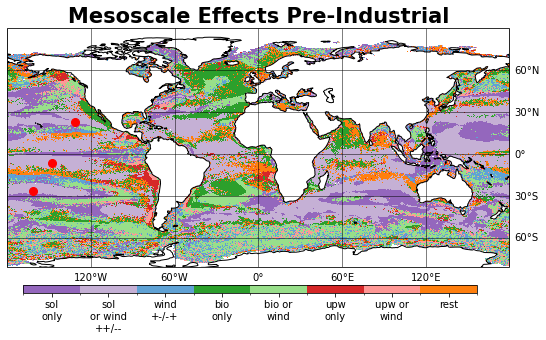

In [125]:
fig, axs= plt.subplots(nrows=1, ncols=1 , figsize=(9,5),subplot_kw={'projection': ccrs.PlateCarree()})
pic=cat.plot(x='geolon_t', y='geolat_t', transform = ccrs.PlateCarree(), add_colorbar=False, cmap=cm,norm=norm)
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.5)
gl.xlabels_top = False
gl.ylabels_left = False
axs.coastlines()
axs.plot(x_geocoord_outoutn, y_geocoord_outoutn, 'ro', markersize=8, transform=ccrs.PlateCarree())
axs.plot(x_geocoord_ininn, y_geocoord_ininn, 'ro', markersize=8, transform=ccrs.PlateCarree())
axs.plot(x_geocoord_sol, y_geocoord_sol, 'ro', markersize=8, transform=ccrs.PlateCarree())

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cbar_ax = fig.add_axes([0.15, 0.1, 0.70, 0.02])
cb = fig.colorbar(pic, cax=cbar_ax,orientation='horizontal', format=fmt, ticks=tickz)
axs.set_title('Mesoscale Effects Pre-Industrial', fontweight='bold', fontsize=21);
#plt.savefig(pathp+'mesoscale_effects_wind_ctrl_median_alt.png', dpi=300, bbox_inches='tight');

In [44]:
y_geocoord_outoutn, x_geocoord_outoutn=-6.734443328377402, -148.15000000000072
y_geocoord_ininn, x_geocoord_ininn=-26.903184428130338, -161.24999999999994

In [46]:
point1n=dsa.sel(xt_ocean=x_geocoord_outoutn, method='nearest').sel(yt_ocean=y_geocoord_outoutn, method='nearest')
point2n=dsa.sel(xt_ocean=x_geocoord_ininn, method='nearest').sel(yt_ocean=y_geocoord_ininn, method='nearest')
point3n=dsa.sel(xt_ocean=x_geocoord_sol, method='nearest').sel(yt_ocean=y_geocoord_sol, method='nearest')

wind1n=windano.sel(xt_ocean=x_geocoord_outoutn, method='nearest').sel(yt_ocean=y_geocoord_outoutn, method='nearest')
wind2n=windano.sel(xt_ocean=x_geocoord_ininn, method='nearest').sel(yt_ocean=y_geocoord_ininn, method='nearest')
wind3n=windano.sel(xt_ocean=x_geocoord_sol, method='nearest').sel(yt_ocean=y_geocoord_sol, method='nearest')

corr1n=corr[['corr_sst_dic_stf', 'corr_sst_o2_stf','corr_o2_stf_dic_stf']].sel(xt_ocean=x_geocoord_outoutn, method='nearest').sel(yt_ocean=y_geocoord_outoutn, method='nearest')
corr2n=corr[['corr_sst_dic_stf', 'corr_sst_o2_stf','corr_o2_stf_dic_stf']].sel(xt_ocean=x_geocoord_ininn, method='nearest').sel(yt_ocean=y_geocoord_ininn, method='nearest')
corr3n=corr[['corr_sst_dic_stf', 'corr_sst_o2_stf','corr_o2_stf_dic_stf']].sel(xt_ocean=x_geocoord_sol, method='nearest').sel(yt_ocean=y_geocoord_sol, method='nearest')

In [47]:
windcorr1_SST=xr.corr(wind1n, point1n.SST)
windcorr1_sh=xr.corr(wind1n, point1n.sens_heat)
windcorr1_co2=xr.corr(wind1n, point1n.dic_stf)
windcorr1_o2=xr.corr(wind1n, point1n.o2_stf)

windcorr2_SST=xr.corr(wind2n, point2n.SST)
windcorr2_sh=xr.corr(wind2n, point2n.sens_heat)
windcorr2_co2=xr.corr(wind2n, point2n.dic_stf)
windcorr2_o2=xr.corr(wind2n, point2n.o2_stf)

windcorr3_SST=xr.corr(wind3n, point3n.SST)
windcorr3_sh=xr.corr(wind3n, point3n.sens_heat)
windcorr3_co2=xr.corr(wind3n, point3n.dic_stf)
windcorr3_o2=xr.corr(wind3n, point3n.o2_stf)

In [48]:
corrs=[str(round(float(corr1n.corr_sst_dic_stf.values),3)), 
       str(round(float(corr2n.corr_sst_dic_stf.values),3)), 
       str(round(float(corr3n.corr_sst_dic_stf.values),3)),
       
       str(round(float(corr1n.corr_sst_o2_stf.values),3)),
       str(round(float(corr2n.corr_sst_o2_stf.values),3)),
       str(round(float(corr3n.corr_sst_o2_stf.values),3)),
       
       str(round(float(corr1n.corr_o2_stf_dic_stf.values),3)),
       str(round(float(corr2n.corr_o2_stf_dic_stf.values),3)),
       str(round(float(corr3n.corr_o2_stf_dic_stf.values),3)),
       
       str(round(float(windcorr1_SST.values),3)),
       str(round(float(windcorr2_SST.values),3)),
       str(round(float(windcorr3_SST.values),3)),
      ]

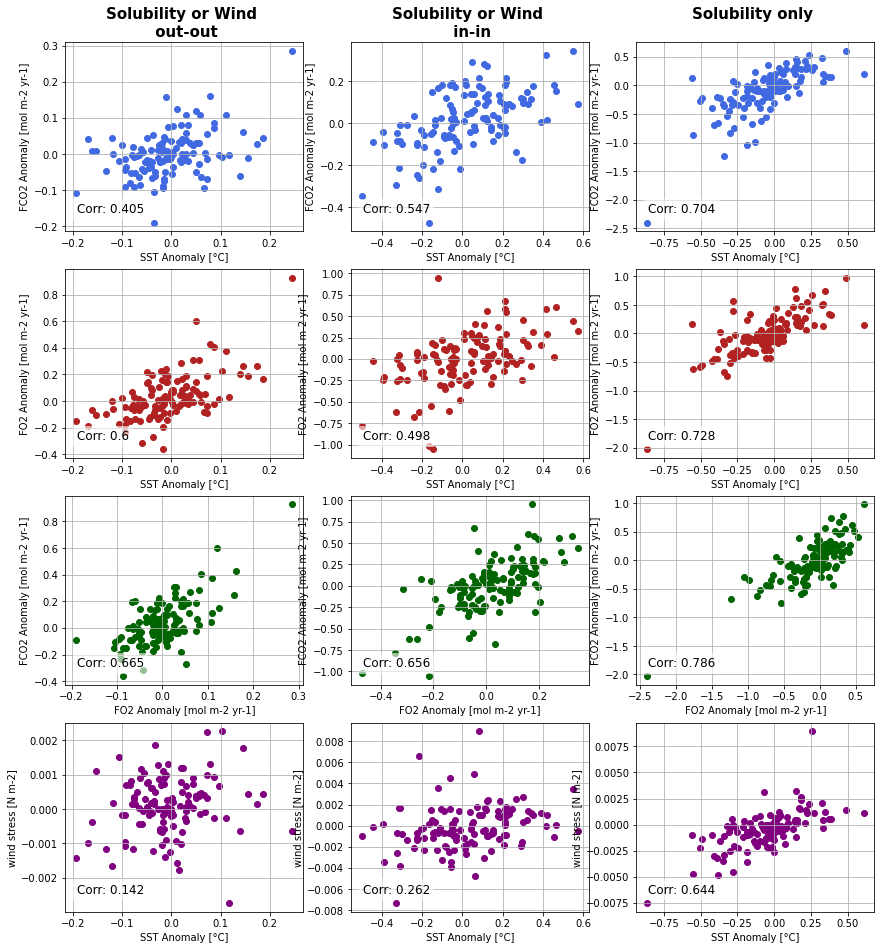

In [49]:
fig, axs=plt.subplots(nrows=4, ncols=3, figsize=(14.5,16))
axs=axs.flatten()
axs[0].scatter(point1n.SST, point1n.dic_stf, c='royalblue')
axs[3].scatter(point1n.SST, point1n.o2_stf, c='firebrick')
axs[6].scatter(point1n.dic_stf, point1n.o2_stf, c='darkgreen')
axs[9].scatter(point1n.SST, wind1n, c='purple')


axs[1].scatter(point2n.SST, point2n.dic_stf, c='royalblue')
axs[4].scatter(point2n.SST, point2n.o2_stf, c='firebrick')
axs[7].scatter(point2n.dic_stf, point2n.o2_stf, c='darkgreen')
axs[10].scatter(point2n.SST, wind2n, c='purple')

axs[2].scatter(point3n.SST, point3n.dic_stf, c='royalblue')
axs[5].scatter(point3n.SST, point3n.o2_stf, c='firebrick')
axs[8].scatter(point3n.dic_stf, point3n.o2_stf, c='darkgreen')
axs[11].scatter(point3n.SST, wind3n, c='purple')

for i in range (3):
    axs[i].set_ylabel('FCO2 Anomaly [mol m-2 yr-1]')
for i in range (3,6):
    axs[i].set_ylabel('FO2 Anomaly [mol m-2 yr-1]')
for i in range (9,12):
    axs[i].set_ylabel('wind stress [N m-2]')
    
for i in range(12):
    axs[i].set_xlabel('SST Anomaly [°C]')
    axs[i].grid()
    axs[i].text(0.05, 0.15, 'Corr: '+ corrs[i],
            transform=axs[i].transAxes,
            fontsize=12,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
for i in range (6,9):
    axs[i].set_ylabel('FCO2 Anomaly [mol m-2 yr-1]')
    axs[i].set_xlabel('FO2 Anomaly [mol m-2 yr-1]')
axs[0].set_title('Solubility or Wind \n out-out', fontweight='bold', fontsize=15)
axs[1].set_title('Solubility or Wind \n in-in', fontweight='bold', fontsize=15)
axs[2].set_title('Solubility only \n', fontweight='bold', fontsize=15)
plt.savefig(pathp+'scatter_solubility_regions4.png', dpi=300, bbox_inches='tight')

## one more try, regions as similar as possible

In [60]:
y_coord_outoutn, x_coord_outoutn, y_geocoord_outoutn, x_geocoord_outoutn=random_point(mask1f,(cat==2)&(outout==1)&(solw>=0.65))###solubility and wind out/out

Selected point at yt_ocean=-7.329927381649533, xt_ocean=-152.45000000000044, geolat_t=-7.329927381649533, geolon_t=-152.45000000000044 with value 100.0


In [124]:
y_coord_ininn, x_coord_ininn, y_geocoord_ininn, x_geocoord_ininn=random_point(mask4f, (cat==2)&(inin==1)&(mask4f>=70)&(solw>=0.65)&(solw<=0.7)) ###solubility and wind in/in

Selected point at yt_ocean=1.6497728018622135, xt_ocean=-49.7500000000053, geolat_t=1.6497728018622135, geolon_t=-49.7500000000053 with value 100.0


In [109]:
y_coord_sol, x_coord_sol, y_geocoord_sol, x_geocoord_sol=random_point(mask2f+mask3f, (cat==1)&(sol>=0.65)&(sol<=0.7)) ###solubility and wind in/in

Selected point at yt_ocean=-0.4499955831023239, xt_ocean=-236.94999999999567, geolat_t=-0.4499955831023239, geolon_t=-236.94999999999567 with value 97.5


In [125]:
point1n=dsa.sel(xt_ocean=x_geocoord_outoutn, method='nearest').sel(yt_ocean=y_geocoord_outoutn, method='nearest')
point2n=dsa.sel(xt_ocean=x_geocoord_ininn, method='nearest').sel(yt_ocean=y_geocoord_ininn, method='nearest')
point3n=dsa.sel(xt_ocean=x_geocoord_sol, method='nearest').sel(yt_ocean=y_geocoord_sol, method='nearest')

wind1n=windano.sel(xt_ocean=x_geocoord_outoutn, method='nearest').sel(yt_ocean=y_geocoord_outoutn, method='nearest')
wind2n=windano.sel(xt_ocean=x_geocoord_ininn, method='nearest').sel(yt_ocean=y_geocoord_ininn, method='nearest')
wind3n=windano.sel(xt_ocean=x_geocoord_sol, method='nearest').sel(yt_ocean=y_geocoord_sol, method='nearest')

corr1n=corr[['corr_sst_dic_stf', 'corr_sst_o2_stf','corr_o2_stf_dic_stf']].sel(xt_ocean=x_geocoord_outoutn, method='nearest').sel(yt_ocean=y_geocoord_outoutn, method='nearest')
corr2n=corr[['corr_sst_dic_stf', 'corr_sst_o2_stf','corr_o2_stf_dic_stf']].sel(xt_ocean=x_geocoord_ininn, method='nearest').sel(yt_ocean=y_geocoord_ininn, method='nearest')
corr3n=corr[['corr_sst_dic_stf', 'corr_sst_o2_stf','corr_o2_stf_dic_stf']].sel(xt_ocean=x_geocoord_sol, method='nearest').sel(yt_ocean=y_geocoord_sol, method='nearest')

In [126]:
windcorr1_SST=xr.corr(wind1n, point1n.SST)
windcorr1_sh=xr.corr(wind1n, point1n.sens_heat)
windcorr1_co2=xr.corr(wind1n, point1n.dic_stf)
windcorr1_o2=xr.corr(wind1n, point1n.o2_stf)

windcorr2_SST=xr.corr(wind2n, point2n.SST)
windcorr2_sh=xr.corr(wind2n, point2n.sens_heat)
windcorr2_co2=xr.corr(wind2n, point2n.dic_stf)
windcorr2_o2=xr.corr(wind2n, point2n.o2_stf)

windcorr3_SST=xr.corr(wind3n, point3n.SST)
windcorr3_sh=xr.corr(wind3n, point3n.sens_heat)
windcorr3_co2=xr.corr(wind3n, point3n.dic_stf)
windcorr3_o2=xr.corr(wind3n, point3n.o2_stf)

In [127]:
corrs=[str(round(float(corr1n.corr_sst_dic_stf.values),3)), 
       str(round(float(corr2n.corr_sst_dic_stf.values),3)), 
       str(round(float(corr3n.corr_sst_dic_stf.values),3)),
       
       str(round(float(corr1n.corr_sst_o2_stf.values),3)),
       str(round(float(corr2n.corr_sst_o2_stf.values),3)),
       str(round(float(corr3n.corr_sst_o2_stf.values),3)),
       
       str(round(float(corr1n.corr_o2_stf_dic_stf.values),3)),
       str(round(float(corr2n.corr_o2_stf_dic_stf.values),3)),
       str(round(float(corr3n.corr_o2_stf_dic_stf.values),3)),
       
       str(round(float(windcorr1_SST.values),3)),
       str(round(float(windcorr2_SST.values),3)),
       str(round(float(windcorr3_SST.values),3)),
      ]

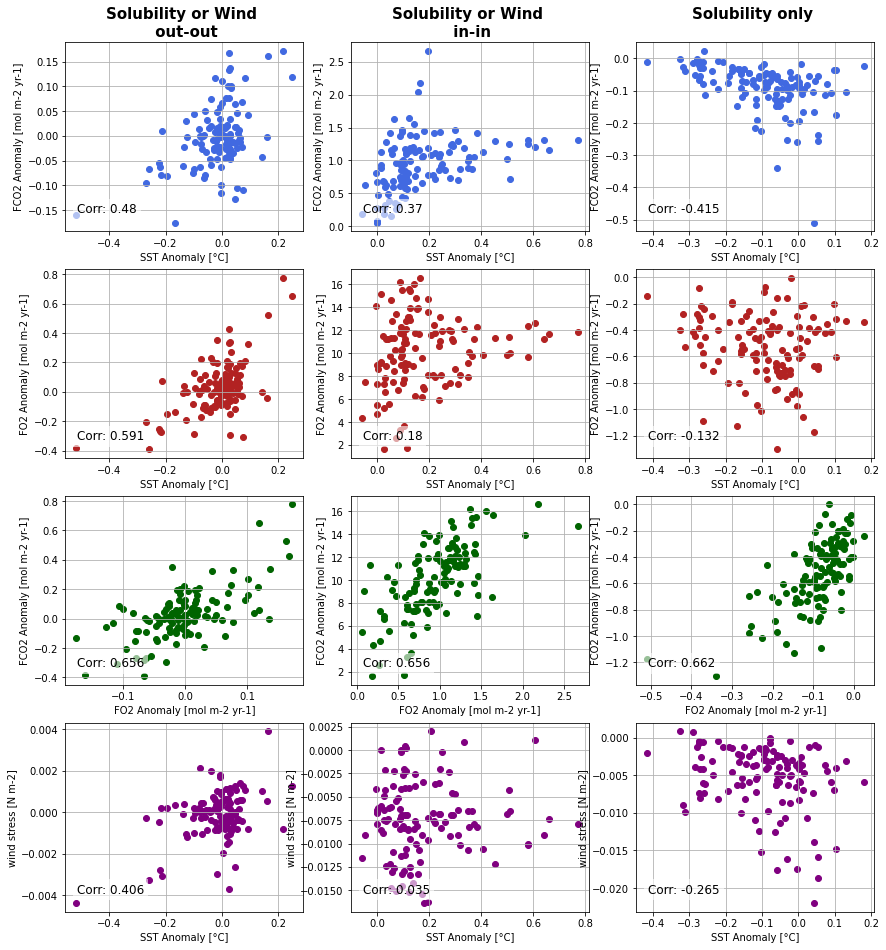

In [128]:
fig, axs=plt.subplots(nrows=4, ncols=3, figsize=(14.5,16))
axs=axs.flatten()
axs[0].scatter(point1n.SST, point1n.dic_stf, c='royalblue')
axs[3].scatter(point1n.SST, point1n.o2_stf, c='firebrick')
axs[6].scatter(point1n.dic_stf, point1n.o2_stf, c='darkgreen')
axs[9].scatter(point1n.SST, wind1n, c='purple')


axs[1].scatter(point2n.SST, point2n.dic_stf, c='royalblue')
axs[4].scatter(point2n.SST, point2n.o2_stf, c='firebrick')
axs[7].scatter(point2n.dic_stf, point2n.o2_stf, c='darkgreen')
axs[10].scatter(point2n.SST, wind2n, c='purple')

axs[2].scatter(point3n.SST, point3n.dic_stf, c='royalblue')
axs[5].scatter(point3n.SST, point3n.o2_stf, c='firebrick')
axs[8].scatter(point3n.dic_stf, point3n.o2_stf, c='darkgreen')
axs[11].scatter(point3n.SST, wind3n, c='purple')

for i in range (3):
    axs[i].set_ylabel('FCO2 Anomaly [mol m-2 yr-1]')
for i in range (3,6):
    axs[i].set_ylabel('FO2 Anomaly [mol m-2 yr-1]')
for i in range (9,12):
    axs[i].set_ylabel('wind stress [N m-2]')
    
for i in range(12):
    axs[i].set_xlabel('SST Anomaly [°C]')
    axs[i].grid()
    axs[i].text(0.05, 0.15, 'Corr: '+ corrs[i],
            transform=axs[i].transAxes,
            fontsize=12,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
for i in range (6,9):
    axs[i].set_ylabel('FCO2 Anomaly [mol m-2 yr-1]')
    axs[i].set_xlabel('FO2 Anomaly [mol m-2 yr-1]')
axs[0].set_title('Solubility or Wind \n out-out', fontweight='bold', fontsize=15)
axs[1].set_title('Solubility or Wind \n in-in', fontweight='bold', fontsize=15)
axs[2].set_title('Solubility only \n', fontweight='bold', fontsize=15)
plt.savefig(pathp+'scatter_solubility_regions5.png', dpi=300, bbox_inches='tight')

# Try with right side of the diagram

In [28]:
inout=xr.where((ds.dic_stf_mean>0) & (ds.o2_stf_mean <0),1, np.nan)
outin=xr.where((ds.dic_stf_mean<0) & (ds.o2_stf_mean >0),1, np.nan)

In [98]:
y_coord_wind1, x_coord_wind1, y_geocoord_wind1, x_geocoord_wind1=random_point(mask3f,(cat==3)&(inout==1)&(wind>=-.70)&(wind<=-.65))

Selected point at yt_ocean=1.5498117803553606, xt_ocean=8.249999999995127, geolat_t=1.5498117803553606, geolon_t=8.249999999995127 with value 100.0


In [99]:
y_coord_wind2, x_coord_wind2, y_geocoord_wind2, x_geocoord_wind2=random_point(mask2f,(cat==3)&(outin==1)&(wind>=-.70)&(wind<=-.65)&(windano.notnull().all(dim='time')))

Selected point at yt_ocean=-42.656597198126484, xt_ocean=-73.45000000000493, geolat_t=-42.656597198126484, geolon_t=-73.45000000000493 with value 99.16666666666667


In [100]:
y_coord_bio1, x_coord_bio1, y_geocoord_bio1, x_geocoord_bio1=random_point(mask3f,(cat==5)&(inout==1)&(biow>=-.70)&(biow<=.65))

Selected point at yt_ocean=3.3480946417062576, xt_ocean=5.449999999995137, geolat_t=3.3480946417062576, geolon_t=5.449999999995137 with value 100.0


In [101]:
y_coord_bio2, x_coord_bio2, y_geocoord_bio2, x_geocoord_bio2=random_point(mask2f,(cat==5)&(outin==1)&(biow>=-.70)&(biow<=.65)&(windano.notnull().all(dim='time')))

Selected point at yt_ocean=-30.153245292054937, xt_ocean=-71.65000000000504, geolat_t=-30.153245292054937, geolon_t=-71.65000000000504 with value 96.66666666666667


In [102]:
y_coord_bio, x_coord_bio, y_geocoord_bio, x_geocoord_bio=random_point(bio,(cat==4)&(bio>=-.70)&(bio<=-.65))

Selected point at yt_ocean=54.60647373129214, xt_ocean=-53.65000000000532, geolat_t=54.60647373129214, geolon_t=-53.65000000000532 with value -0.6500086537199244


In [103]:
point1n=dsa.sel(xt_ocean=x_geocoord_wind1, method='nearest').sel(yt_ocean=y_geocoord_wind1, method='nearest')
point2n=dsa.sel(xt_ocean=x_geocoord_wind2, method='nearest').sel(yt_ocean=y_geocoord_wind2, method='nearest')
point3n=dsa.sel(xt_ocean=x_geocoord_bio1, method='nearest').sel(yt_ocean=y_geocoord_bio1, method='nearest')
point4n=dsa.sel(xt_ocean=x_geocoord_bio2, method='nearest').sel(yt_ocean=y_geocoord_bio2, method='nearest')
point5n=dsa.sel(xt_ocean=x_geocoord_bio, method='nearest').sel(yt_ocean=y_geocoord_bio, method='nearest')


wind1n=windano.sel(xt_ocean=x_geocoord_wind1, method='nearest').sel(yt_ocean=y_geocoord_wind1, method='nearest')
wind2n=windano.sel(xt_ocean=x_geocoord_wind2, method='nearest').sel(yt_ocean=y_geocoord_wind2, method='nearest')
wind3n=windano.sel(xt_ocean=x_geocoord_bio1, method='nearest').sel(yt_ocean=y_geocoord_bio1, method='nearest')
wind4n=windano.sel(xt_ocean=x_geocoord_bio2, method='nearest').sel(yt_ocean=y_geocoord_bio2, method='nearest')
wind5n=windano.sel(xt_ocean=x_geocoord_bio, method='nearest').sel(yt_ocean=y_geocoord_bio, method='nearest')



corr1n=corr[['corr_sst_dic_stf', 'corr_sst_o2_stf','corr_o2_stf_dic_stf']].sel(xt_ocean=x_geocoord_wind1, method='nearest').sel(yt_ocean=y_geocoord_wind1, method='nearest')
corr2n=corr[['corr_sst_dic_stf', 'corr_sst_o2_stf','corr_o2_stf_dic_stf']].sel(xt_ocean=x_geocoord_wind2, method='nearest').sel(yt_ocean=y_geocoord_wind2, method='nearest')
corr3n=corr[['corr_sst_dic_stf', 'corr_sst_o2_stf','corr_o2_stf_dic_stf']].sel(xt_ocean=x_geocoord_bio1, method='nearest').sel(yt_ocean=y_geocoord_bio1, method='nearest')
corr4n=corr[['corr_sst_dic_stf', 'corr_sst_o2_stf','corr_o2_stf_dic_stf']].sel(xt_ocean=x_geocoord_bio2, method='nearest').sel(yt_ocean=y_geocoord_bio2, method='nearest')
corr5n=corr[['corr_sst_dic_stf', 'corr_sst_o2_stf','corr_o2_stf_dic_stf']].sel(xt_ocean=x_geocoord_bio, method='nearest').sel(yt_ocean=y_geocoord_bio, method='nearest')


In [106]:
windcorr1_SST=xr.corr(wind1n, point1n.SST)
windcorr1_sh=xr.corr(wind1n, point1n.sens_heat)
windcorr1_co2=xr.corr(wind1n, point1n.dic_stf)
windcorr1_o2=xr.corr(wind1n, point1n.o2_stf)

windcorr2_SST=xr.corr(wind2n, point2n.SST)
windcorr2_sh=xr.corr(wind2n, point2n.sens_heat)
windcorr2_co2=xr.corr(wind2n, point2n.dic_stf)
windcorr2_o2=xr.corr(wind2n, point2n.o2_stf)

windcorr3_SST=xr.corr(wind3n, point3n.SST)
windcorr3_sh=xr.corr(wind3n, point3n.sens_heat)
windcorr3_co2=xr.corr(wind3n, point3n.dic_stf)
windcorr3_o2=xr.corr(wind3n, point3n.o2_stf)

windcorr4_SST=xr.corr(wind4n, point4n.SST)
windcorr4_sh=xr.corr(wind4n, point4n.sens_heat)
windcorr4_co2=xr.corr(wind4n, point4n.dic_stf)
windcorr4_o2=xr.corr(wind4n, point4n.o2_stf)

windcorr5_SST=xr.corr(wind5n, point5n.SST)
windcorr5_sh=xr.corr(wind5n, point5n.sens_heat)
windcorr5_co2=xr.corr(wind5n, point5n.dic_stf)
windcorr5_o2=xr.corr(wind5n, point5n.o2_stf)

corrs=[str(round(float(corr1n.corr_sst_dic_stf.values),3)), 
       str(round(float(corr2n.corr_sst_dic_stf.values),3)), 
       str(round(float(corr3n.corr_sst_dic_stf.values),3)),
       str(round(float(corr4n.corr_sst_dic_stf.values),3)),
       str(round(float(corr5n.corr_sst_dic_stf.values),3)),
       
       str(round(float(corr1n.corr_sst_o2_stf.values),3)),
       str(round(float(corr2n.corr_sst_o2_stf.values),3)),
       str(round(float(corr3n.corr_sst_o2_stf.values),3)),
       str(round(float(corr4n.corr_sst_o2_stf.values),3)),
       str(round(float(corr5n.corr_sst_o2_stf.values),3)),
       
       str(round(float(corr1n.corr_o2_stf_dic_stf.values),3)),
       str(round(float(corr2n.corr_o2_stf_dic_stf.values),3)),
       str(round(float(corr3n.corr_o2_stf_dic_stf.values),3)),
       str(round(float(corr4n.corr_o2_stf_dic_stf.values),3)),
       str(round(float(corr5n.corr_o2_stf_dic_stf.values),3)),
       
       str(round(float(windcorr1_SST.values),3)),
       str(round(float(windcorr2_SST.values),3)),
       str(round(float(windcorr3_SST.values),3)),
       str(round(float(windcorr4_SST.values),3)),
       str(round(float(windcorr5_SST.values),3)),

       str(round(float(windcorr1_co2.values),3)),
       str(round(float(windcorr2_co2.values),3)),
       str(round(float(windcorr3_co2.values),3)),
       str(round(float(windcorr4_co2.values),3)),
       str(round(float(windcorr5_co2.values),3)),

       str(round(float(windcorr1_o2.values),3)),
       str(round(float(windcorr2_o2.values),3)),
       str(round(float(windcorr3_o2.values),3)),
       str(round(float(windcorr4_o2.values),3)),
       str(round(float(windcorr5_o2.values),3))
      ]

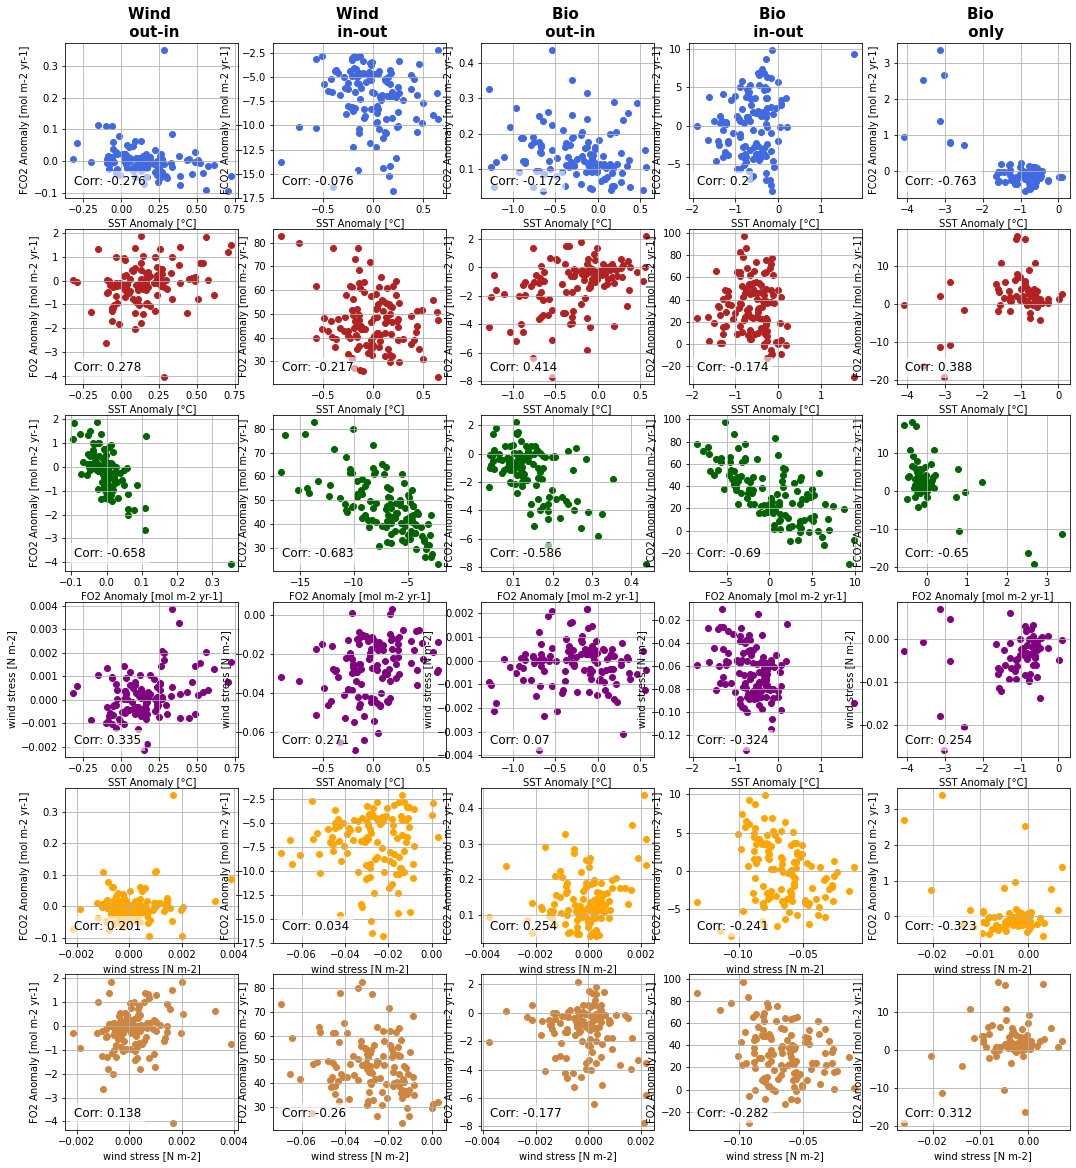

In [107]:
fig, axs=plt.subplots(nrows=6, ncols=5, figsize=(18,20))
axs=axs.flatten()
axs[0].scatter(point1n.SST, point1n.dic_stf, c='royalblue')
axs[1].scatter(point2n.SST, point2n.dic_stf, c='royalblue')
axs[2].scatter(point3n.SST, point3n.dic_stf, c='royalblue')
axs[3].scatter(point4n.SST, point4n.dic_stf, c='royalblue')
axs[4].scatter(point5n.SST, point5n.dic_stf, c='royalblue')

axs[5].scatter(point1n.SST, point1n.o2_stf, c='firebrick')
axs[6].scatter(point2n.SST, point2n.o2_stf, c='firebrick')
axs[7].scatter(point3n.SST, point3n.o2_stf, c='firebrick')
axs[8].scatter(point4n.SST, point4n.o2_stf, c='firebrick')
axs[9].scatter(point5n.SST, point5n.o2_stf, c='firebrick')


axs[10].scatter(point1n.dic_stf, point1n.o2_stf, c='darkgreen')
axs[11].scatter(point2n.dic_stf, point2n.o2_stf, c='darkgreen')
axs[12].scatter(point3n.dic_stf, point3n.o2_stf, c='darkgreen')
axs[13].scatter(point4n.dic_stf, point4n.o2_stf, c='darkgreen')
axs[14].scatter(point5n.dic_stf, point5n.o2_stf, c='darkgreen')


axs[15].scatter(point1n.SST, wind1n, c='purple')
axs[16].scatter(point2n.SST, wind2n, c='purple')
axs[17].scatter(point3n.SST, wind3n, c='purple')
axs[18].scatter(point4n.SST, wind4n, c='purple')
axs[19].scatter(point5n.SST, wind5n, c='purple')

axs[20].scatter(wind1n, point1n.dic_stf, c='orange')
axs[21].scatter(wind2n, point2n.dic_stf, c='orange')
axs[22].scatter(wind3n, point3n.dic_stf, c='orange')
axs[23].scatter(wind4n, point4n.dic_stf, c='orange')
axs[24].scatter(wind5n, point5n.dic_stf, c='orange')

axs[25].scatter(wind1n, point1n.o2_stf, c='peru')
axs[26].scatter(wind2n, point2n.o2_stf, c='peru')
axs[27].scatter(wind3n, point3n.o2_stf, c='peru')
axs[28].scatter(wind4n, point4n.o2_stf, c='peru')
axs[29].scatter(wind5n, point5n.o2_stf, c='peru')

for i in range (5):
    axs[i].set_ylabel('FCO2 Anomaly [mol m-2 yr-1]')
for i in range (5,15):
    axs[i].set_ylabel('FO2 Anomaly [mol m-2 yr-1]')
for i in range (15,20):
    axs[i].set_ylabel('wind stress [N m-2]')
    
for i in range(30):
    axs[i].set_xlabel('SST Anomaly [°C]')
    axs[i].grid()
    axs[i].text(0.05, 0.15, 'Corr: '+ corrs[i],
            transform=axs[i].transAxes,
            fontsize=12,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
for i in range (10,15):
    axs[i].set_ylabel('FCO2 Anomaly [mol m-2 yr-1]')
    axs[i].set_xlabel('FO2 Anomaly [mol m-2 yr-1]')
for i in range (20,30):
    axs[i].set_ylabel('FCO2 Anomaly [mol m-2 yr-1]')
    axs[i].set_xlabel('wind stress [N m-2]')
for i in range (25,30):
    axs[i].set_ylabel('FO2 Anomaly [mol m-2 yr-1]')
    
axs[0].set_title('Wind \n out-in', fontweight='bold', fontsize=15)
axs[1].set_title('Wind \n in-out', fontweight='bold', fontsize=15)
axs[2].set_title('Bio \n out-in', fontweight='bold', fontsize=15)
axs[3].set_title('Bio \n in-out', fontweight='bold', fontsize=15)
axs[4].set_title('Bio \n only', fontweight='bold', fontsize=15)

plt.savefig(pathp+'scatter_rightside_regions.png', dpi=300, bbox_inches='tight')

# function for slopes, means and median

In [228]:
def slope(arraylist, namelist, SSTanomaly):
    #lists are 2-Dimensional 
    #arraylist contains pairs of arrays that the correlation should be calculated
    #namelist contains a string with the variable names
    #SSTanomaly has to be the respective SST anomaly data
    for i in range(len(arraylist)):
        ##calculate slope and pearson corr
        data1=arraylist[i][0]
        data2=arraylist[i][1]
        var1=namelist[i][0]
        var2=namelist[i][1]
        if data1.isnull().all()==True:
            return "Only nan values"
        elif data2.isnull().all()==True:
            return "Only nan values"
        else:
            #calculate anticyclone and cyclone mean and median
            anticycl1=data1.where(SSTanomaly>0)
            cycl1=data1.where(SSTanomaly<0)
            mean1_ac=anticycl1.mean().values
            mean1_c=cycl1.mean().values
            median1_ac=anticycl1.median().values
            median1_c=cycl1.median().values
    
            anticycl2=data2.where(SSTanomaly>0)
            cycl2=data2.where(SSTanomaly<0)
            mean2_ac=anticycl2.mean().values
            mean2_c=cycl2.mean().values
            median2_ac=anticycl2.median().values
            median2_c=cycl2.median().values
    
            #statistics
            data1_1d=data1.values.flatten()
            data2_1d=data2.values.flatten()
            mask = ~np.isnan(data1_1d) & ~np.isnan(data2_1d)
            result = stats.linregress(data1_1d[mask],data2_1d[mask])
            

            print('___________'+var1+'-'+var2+':___________') 
            print('slope: '+ str(round(result.slope,3)))
            print('rvalue: '+ str(round(result.rvalue,3)))
            print('----Anticyclone:----')
            print('mean: '+var1+' '+str(np.round(mean1_ac,3))+' '+var2+' '+ str(np.round(mean2_ac,3)))
            print('median: '+var1+' '+str(np.round(median1_ac,3))+' '+var2+' '+ str(np.round(median2_ac,3)))
            print('----Cyclone:-------- ')
            print('mean: '+var1+' '+str(np.round(mean1_c,3))+' '+var2+' '+ str(np.round(mean2_c,3)))
            print('median: '+var1+' '+str(np.round(median1_c,3))+' '+var2+' '+ str(np.round(median2_c,3)))
            print()

In [198]:
slope([[wind4n, point4n.SST], [point4n.dic_stf, point4n.o2_stf]],[['wind stress', 'SST'], ['CO2', 'O2']], point4n.SST )

___________wind stress-SST:___________
slope: -7.258
rvalue: -0.324
----Anticyclone:----
mean: wind stress -0.067 SST 0.34
median: wind stress -0.065 SST 0.072
----Cyclone:---- 
mean: wind stress -0.066 SST -0.66
median: wind stress -0.067 SST -0.603

___________CO2-O2:___________
slope: -4.136
rvalue: -0.69
----Anticyclone:----
mean: CO2 3.066 O2 6.04
median: CO2 2.863 O2 3.662
----Cyclone:---- 
mean: CO2 -0.118 O2 34.495
median: CO2 0.212 O2 33.347



In [188]:
##try more dimensional

In [224]:
test=dsa.isel(xt_ocean=slice(400,411)).isel(yt_ocean=slice(400,411))

In [230]:
slope([[test.dic_stf, test.o2_stf], [test.dic_stf, test.SST]],[['CO2', 'O2'], ['CO2', 'SST']], test.SST )

___________CO2-O2:___________
slope: -4.845
rvalue: -0.821
----Anticyclone:----
mean: CO2 -0.226 O2 0.948
median: CO2 -0.143 O2 0.141
----Cyclone:-------- 
mean: CO2 -0.094 O2 0.744
median: CO2 -0.057 O2 0.36

___________CO2-SST:___________
slope: -0.145
rvalue: -0.267
----Anticyclone:----
mean: CO2 -0.226 SST 0.096
median: CO2 -0.143 SST 0.078
----Cyclone:-------- 
mean: CO2 -0.094 SST -0.182
median: CO2 -0.057 SST -0.116

